In [1]:
import warnings; warnings.filterwarnings('ignore')
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import df_stats, df_changes

## Data Extraction

The data are split over several csv files. Here we load the date into a single dataframe.

Print the structure of the csv files in the folder data/

In [2]:
files = [i for i in glob.glob('data/ka-feedback-*.csv')]
csv_columns = [pd.read_csv(f).columns for f in files]
for row in csv_columns:
    for item in row:
        print(item, end=' ')
    print('')

Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal 
Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal 
Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal 
Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal 
Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal 
Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal 
Vorgangsnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal 
Vorgangsnnummer Kategorie Ort Zustand Erstellungsdatum Letztes Bearbeitungsdatum Eingangskanal 


Suggestions:  
1. Each file has the same columns => Concatenate dataframes  
2. Two date columns => Parse dates  
3. Note typo in the first column of last file => Translate column name  

Concerning date parsing, two different time zones are used in the data:  
- CET = UTC + 1  (winter time)  
- CEST = UTC + 2  (summer time)   

but neither of these time zones are in place at the same time of the year.

Example:

In [3]:
one = pd.read_csv(files[1], parse_dates=['Erstellungsdatum'])
print(one['Erstellungsdatum'][0], " -> winter time")
print(one['Erstellungsdatum'][1300], " -> summer time")

2013-12-31 18:46:00+01:00  -> winter time
2013-07-28 17:59:00+02:00  -> summer time


In order to compare winter and summer results, will be best to strip the timezone information.

Example:

In [4]:
one = pd.read_csv(files[1], parse_dates=['Erstellungsdatum'],
                  date_parser=lambda col: pd.to_datetime(col).tz_localize(None))
print(one['Erstellungsdatum'][0], " -> local time")
print(one['Erstellungsdatum'][1300], " -> local time")

2013-12-31 18:46:00  -> local time
2013-07-28 17:59:00  -> local time


Following all the suggestions above, here we load all data into a dataframe.

In [5]:
# Load data from csv files into dataframe
def read_csv(file):
    # Read csv and parse dates 
    df = pd.read_csv(file, 
                     parse_dates=['Erstellungsdatum','Letztes Bearbeitungsdatum'],
                     date_parser=lambda col: pd.to_datetime(col).tz_localize(None)
                    )
    # Fix typo in column name
    df = df.rename(columns={'Vorgangsnnummer':'Vorgangsnummer'})
    return df

# Concat dataframes
df = pd.concat(map(read_csv, files), ignore_index=True)

# Optimize datatypes
df = df.convert_dtypes()

# Sort by Erstellungsdatum, as future entries will arrive in order of this quantity
df = df.sort_values('Erstellungsdatum', ignore_index=True)

# Print changes
df_changes(df,'ka',init=True)

Now tracking changes to dataframe (label='ka')
Added 58449 rows
Added 7 columns:
- Erstellungsdatum (datetime64[ns])
- Vorgangsnummer (string)
- Kategorie (string)
- Zustand (string)
- Ort (string)
- Letztes Bearbeitungsdatum (datetime64[ns])
- Eingangskanal (string)


## Data Cleaning

Here we perform basic data cleaning.

First show a few rows:

In [6]:
df.head(5)

,Vorgangsnummer,Kategorie,Ort,Zustand,Erstellungsdatum,Letztes Bearbeitungsdatum,Eingangskanal
0,3m6hno,Verkehrsverstöße,"Basler-Tor-Straße 29-30, 76227 Karlsruhe",Behoben,2012-02-24 22:16:00,2015-03-20 09:59:00,MOBILE
1,fsaeor,Verkehrsverstöße,"Gärtnerstraße 17, 76227 Karlsruhe",Behoben,2012-03-04 17:42:00,2015-03-20 10:00:00,MOBILE
2,blm3gf,Verkehrsverstöße,"Georg-Büchner-Straße 4, 76149 Karlsruhe",Behoben,2012-03-07 20:31:00,2015-03-20 10:00:00,MOBILE
3,2cfufu,Straßenbeleuchtung,"Stadtwerke, 76185 Karlsruhe",Abgeschlossen,2012-03-09 10:20:00,2017-01-11 13:28:00,MOBILE
4,riwctt,Verkehrsverstöße,"Henriette-Obermüller-Straße 10, 76137 Karlsruhe",Behoben,2012-03-11 17:22:00,2012-03-11 17:22:00,MOBILE


and count NA's and unique values:

In [7]:
df_stats(df)

Shape:(58449, 7)
                                    dtype   #NA  %NA  #unique
Vorgangsnummer                     string     0    0    58445
Kategorie                          string     0    0       24
Ort                                string  4069    6    24307
Zustand                            string     0    0        4
Erstellungsdatum           datetime64[ns]     0    0    55397
Letztes Bearbeitungsdatum  datetime64[ns]     0    0    49693
Eingangskanal                      string     0    0        3


**Action:** 
- Drop column `Vorgangsnummer`, which is a unique identifier without logical information.

In [8]:
df = df.drop('Vorgangsnummer', axis=1)
df_changes(df,'ka')

Removed 1 column:
- Vorgangsnummer (string)


**Action:** 
- Drop duplicate rows

In [9]:
df = df.drop_duplicates()
df_changes(df,'ka')

Removed 569 rows


**Action:** 
- Replace NA in `Ort` by '-'

In [10]:
df = df.fillna(value={'Ort':'-'})
df_changes(df,'ka')

## Data Analysis

Here we analyse the data
- for gaining familiarity with the data, and 
- for finding aspects that need to be cleaned up

Show a few rows:

In [11]:
df.head(5)

,Kategorie,Ort,Zustand,Erstellungsdatum,Letztes Bearbeitungsdatum,Eingangskanal
0,Verkehrsverstöße,"Basler-Tor-Straße 29-30, 76227 Karlsruhe",Behoben,2012-02-24 22:16:00,2015-03-20 09:59:00,MOBILE
1,Verkehrsverstöße,"Gärtnerstraße 17, 76227 Karlsruhe",Behoben,2012-03-04 17:42:00,2015-03-20 10:00:00,MOBILE
2,Verkehrsverstöße,"Georg-Büchner-Straße 4, 76149 Karlsruhe",Behoben,2012-03-07 20:31:00,2015-03-20 10:00:00,MOBILE
3,Straßenbeleuchtung,"Stadtwerke, 76185 Karlsruhe",Abgeschlossen,2012-03-09 10:20:00,2017-01-11 13:28:00,MOBILE
4,Verkehrsverstöße,"Henriette-Obermüller-Straße 10, 76137 Karlsruhe",Behoben,2012-03-11 17:22:00,2012-03-11 17:22:00,MOBILE


Count NA's and unique values:

In [12]:
df_stats(df)

Shape:(57880, 6)
                                    dtype  #NA  %NA  #unique
Kategorie                          string    0    0       24
Ort                                string    0    0    24307
Zustand                            string    0    0        4
Erstellungsdatum           datetime64[ns]    0    0    55397
Letztes Bearbeitungsdatum  datetime64[ns]    0    0    49693
Eingangskanal                      string    0    0        3


We inspect each column in more detail below.

### Categorical columns

#### `Kategorie`

List the 24 unique values for `Kategorie`:

In [13]:
df['Kategorie'].value_counts()

Verunreinigungen                                         14302
115 Abfallsammlung                                        9113
Verkehrsverstöße                                          7806
Gefahrenstellen                                           5876
Straßenbeleuchtung                                        4429
115 Straßenreinigung                                      4175
Beschilderung und Verkehrsführung                         3610
OA 6 Aufenthalt Nicht-EU                                  1525
Ampel                                                     1453
Beschilderung                                             1427
KA-Feedback Nutzerumfrage                                 1231
Bauliche Mängel                                            829
Ampeln für Fußgänger oder Radfahrer                        454
115 Abfall Sperrmüll/Weiße Ware (2nd Level)                438
Ampel für Kraftfahrzeuge                                   407
OA 6 Terminwunsch ohne eMail-Adresse                   

Visualise frequencies as a pie chart:

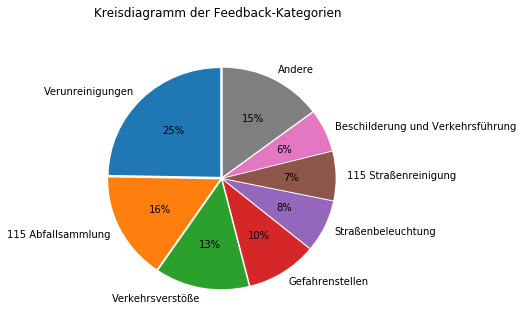

In [14]:
threshold = 2000
freq = df['Kategorie'].value_counts()
mask = freq < threshold
freq = freq[~mask].append(pd.Series([freq[mask].sum()],index=['Andere']))

title = 'Kreisdiagramm der Feedback-Kategorien'
fig, axes = plt.subplots(figsize=(5,5));
freq.plot(kind='pie', autopct='%1.f%%', startangle=90, explode=[0.02]*len(freq), ax=axes);
fig.suptitle(title);
axes.set_ylabel('');

Two categories contain the word 'Test':

In [15]:
test_categories = [cat for cat in df['Kategorie'].unique() if 'Test' in cat]
test_categories

['Beschwerde Test', 'Test']

How many rows would be removed upon cleaning?

In [16]:
len(df[df['Kategorie'].isin(test_categories)])

27

This is a small number so these rows can safely be removed.

**Action:** 
- Drop the values 'Test' and 'Beschwerde Test' in column `Kategorie`

In [17]:
df = df[~df['Kategorie'].isin(test_categories)]
df_changes(df,'ka')

Removed 27 rows


#### `Ort`

Plot histogram of string length for the locations in `Ort`:

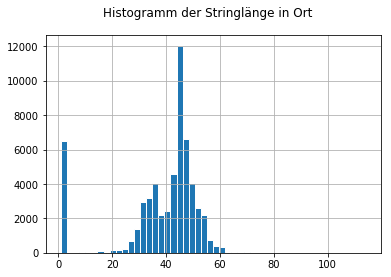

In [18]:
df['Ort'].apply(len).hist(bins=50, ec='white');
plt.suptitle('Histogramm der Stringlänge in Ort');

The spike on the left shows that there are thousands of unknown addresses.
We will deal with that later.

#### `Eingangskanal`

List the 3 unique values for `Eingangskanal`:

In [19]:
df['Eingangskanal'].value_counts()

CALL_115    26957
MOBILE      24336
WEB          6560
Name: Eingangskanal, dtype: Int64

Website usage lags behind phone and mobile. 
This makes sense, given the categories of feedback listed above, which mostly pertain situations in the public space outside on the street.
Other than that, this column looks clean. 

#### `Zustand`

List the 4 unique values for `Zustand`:

In [20]:
df['Zustand'].value_counts()

Abgeschlossen    35972
Eingetroffen     10210
Behoben           9554
In Arbeit         2117
Name: Zustand, dtype: Int64

Visualise in a pie chart:

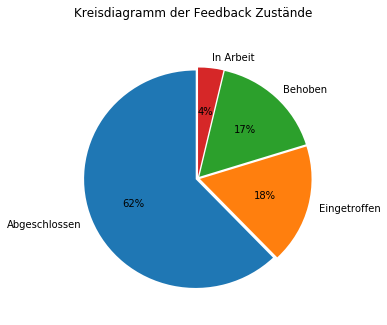

In [21]:
freq = df['Zustand'].value_counts()
title = 'Kreisdiagramm der Feedback Zustände'
fig, axes = plt.subplots(figsize=(5,5));
fig.suptitle(title);
freq.plot(kind='pie', autopct='%1.f%%', startangle=90, explode=[0.02]*len(freq), ax=axes);
axes.set_ylabel('');

These values should be interpreted as follows:  
- 'Eingetroffen': Feedback received.  
- 'In Arbeit': Feedback is being acted upon.  
- 'Behoben': Feedback was acted upon succesfully.  
- 'Abgeschlossen': Feedback closed without intervention.  

Typical Feedback-status lifecycles are:  
- 'Eingetroffen' -> 'In Arbeit' -> 'Behoben'  
- 'Eingetroffen' -> 'Abgeschlossen'

This column will be the basis for a label.

### Date columns

Plot individual distributions of year, month, day and hour:

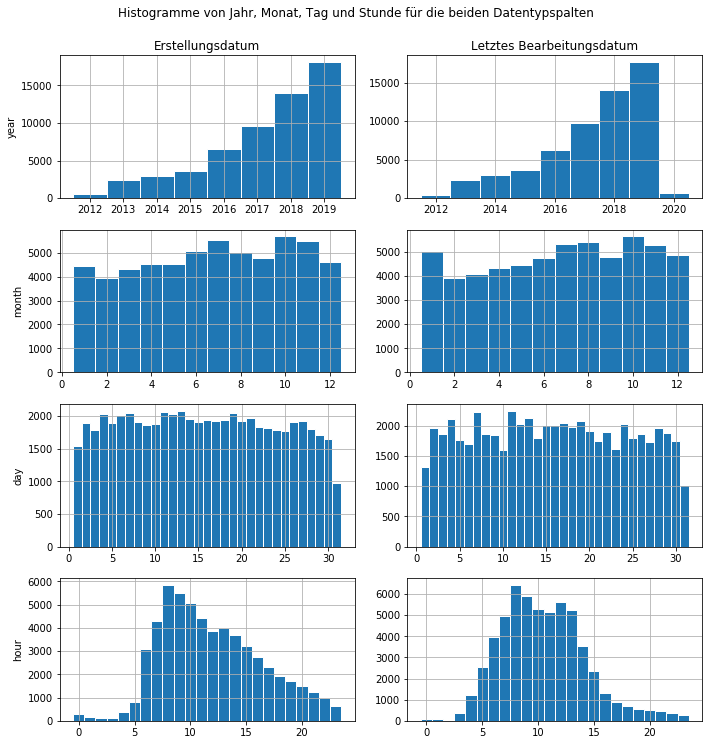

In [22]:
cols = ['Erstellungsdatum', 
        'Letztes Bearbeitungsdatum']

units = ['year', 
         'month', 
         'day', 
         'hour']

title = 'Histogramme von Jahr, Monat, Tag und Stunde für die beiden Datentypspalten'
fig, axes = plt.subplots(len(units), len(cols), figsize=(10,10))
for j,col in enumerate(cols):
    axes[0, j].set_title(col)
    for i,unit in enumerate(units):
        axes[i, 0].set_ylabel(unit)
        values = getattr(df[col].dt, unit)
        bins = list(map(lambda x: x-0.5, range(min(values),max(values)+2)))
        values.hist(bins=bins, ax=axes[i, j], ec='white');
fig.tight_layout();
fig.suptitle(title, y=1.03);

Highlight usage of the service per year:

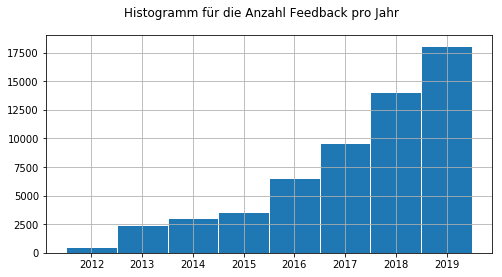

In [23]:
title = 'Histogramm für die Anzahl Feedback pro Jahr'
fig, axes = plt.subplots(figsize=(8,4))
fig.suptitle(title)
yearly = df['Erstellungsdatum'].dt.year;
bins = list(map(lambda x: x-0.5, range(min(yearly),max(yearly)+2)))
yearly.hist(bins=bins, ec='white', ax=axes);

Observations:  
1. The year histograms show a clear increase in feedback over the years  
2. The month and day histograms are rather flat: no outliers  
3. Hour of the day distribution shows most activity in the morning and gradually less during the day. 

Investigate possible correlations between different time units:
- Although month and day (of month) are flatly distributed, are there specific busy days in the year?

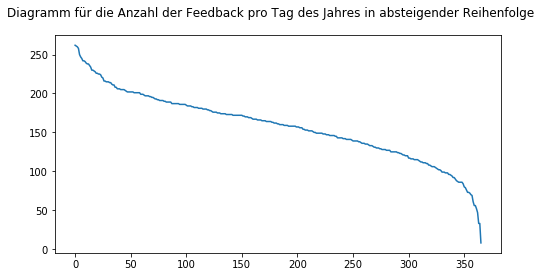

In [24]:
# Which day of the year is most feedback given?
col = 'Erstellungsdatum'
units = ['month', 'day']

copy = pd.DataFrame()
copy[units[0]] = getattr(df[col].dt, units[0])
copy[units[1]] = getattr(df[col].dt, units[1])
copy = copy.groupby(list(copy.columns)).size().reset_index(name='count')

title = 'Diagramm für die Anzahl der Feedback pro Tag des Jahres in absteigender Reihenfolge'
fig, axes = plt.subplots(figsize=(8,4))
fig.suptitle(title);
sorted_counts = copy.sort_values('count', ascending=False).reset_index(drop=True)['count']
sorted_counts.plot(ax=axes);

There are no strong outliers, as seen from this 'S'-shaped graph. 
- Busy days are quite spread out: there are about 50 days in the year with between 200 and 260 feedbacks per day.
- Quiet days are little more sparse: there are about 10 days with 50 feedbacks or less.

We can check the spread over the year with a heatmap:

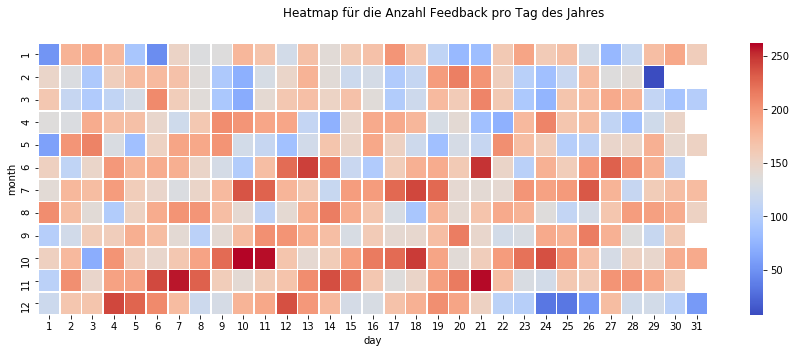

In [25]:
copy_pivot = copy.pivot(index=units[0], columns=units[1], values='count')

title = 'Heatmap für die Anzahl Feedback pro Tag des Jahres'
fig, axes = plt.subplots(figsize=(15,5))
fig.suptitle(title)
sns.heatmap(copy_pivot, linewidth=0.5, ax=axes, cmap='coolwarm');

The heatmap confirms a roughly uniform spread over the year. 
The extrema (red/blue) do not typically seem to correlate with special days. 
At most, the Christmas period (24-26 Dec) is relatively quiet.

Investigate further possible correlations between different time units:
- Are there particularly busy times in the week?

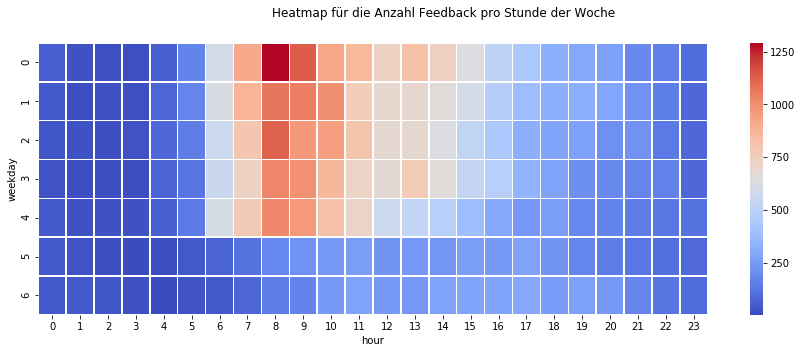

In [26]:
col = 'Erstellungsdatum'
units = ['weekday', 'hour']

copy = pd.DataFrame()
copy[units[0]] = getattr(df[col].dt, units[0])
copy[units[1]] = getattr(df[col].dt, units[1])
copy = copy.groupby(list(copy.columns)).size().reset_index(name='count')
copy = copy.pivot(index=units[0], columns=units[1], values='count')

title = 'Heatmap für die Anzahl Feedback pro Stunde der Woche'
fig, axes = plt.subplots(figsize=(15,5))
fig.suptitle(title)
sns.heatmap(copy, linewidth=0.5, ax=axes, cmap='coolwarm');

Yes, it is particularly busy on Monday morning. The weekend is very calm, instead.

**Advice:** allocate most resources on feedback monitoring in the mornings (before lunch time) during regular working days (Mon-Fri).

## Data Export

Export the cleaned dataframe to a csv-file:

In [27]:
df.to_csv('data/preprocessed_data.csv', index=False)

Import with:  
df = pd.read_csv('data/preprocessed_data.csv', parse_dates=['Erstellungsdatum','Letztes Bearbeitungsdatum']).convert_dtypes()

In [28]:
# Check that re-import produces the same dataframe
imported_df = pd.read_csv('data/preprocessed_data.csv', 
                          parse_dates=['Erstellungsdatum','Letztes Bearbeitungsdatum']
                         ).convert_dtypes()
assert imported_df.shape == df.shape
assert imported_df.dtypes.to_list() == df.dtypes.to_list()
assert all([df[col].to_list() == imported_df[col].to_list() for col in df.columns])